# CPSC 330 - Applied Machine Learning 

## Homework 2: Decision trees and machine learning fundamentals 
### Associated lectures: [Lectures 2 and 3](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Monday Sep 20, 2021 at 11:59pm**

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier

## Instructions
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). In particular, **see the note about not pushing downloaded data to your repo**.

You are welcome to broadly discuss questions with your classmates but your final answers must be your own. **We are not allowing group submission for this homework assignment.**  

## Introducing the data set
 
For this  assignment you'll be looking at Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/) dataset.
The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it to the same directory as this notebook.

## Exercise 1: Exploratory data analysis

#### 1(a) 
rubric={points:2}

Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column of the .csv file should be set as the index.

In [29]:
spotify_df = pd.read_csv('spotify.csv');

#### 1(b)
rubric={points:2}

Run the following line of code to split the data. How many training and test examples do we have?

> Note: we are setting the `random_state` so that everyone has the same split on their assignments. This will make it easier for the TAs to grade.

In [30]:
df_train, df_test = train_test_split(spotify_df, test_size=0.2, random_state=321)
print('There are', df_train.index.size, 'training examples')
print('There are', df_test.index.size, 'test examples')

There are 1613 training examples
There are 404 test examples


#### 1(c)
rubric={points:3}

- Print out the output of `describe()` **on the training split**. This will compute some summary statistics of the numeric columns.
- Which feature has the smallest range? 

> Hint: You can subtract the min value from the max value of the column to get the range.

Note that `describe` returns another DataFrame.

In [31]:
train_desc = df_train.describe()
# for col in train_desc:
#     print(col, train_desc[col]["max"] - train_desc[col]["min"])
print('speachiness has the smallest range.')

speachiness has the smallest range.


#### 1(d) 
rubric={points:5}

Let's focus on the following features:

- danceability
- tempo
- energy
- valence

For each of these features (in order), produce a histogram that shows the distribution of the feature values in the training set, **separated for positive and negative examples**. 
By "positive examples" we mean target = 1 (user liked the song, positive sentiment) and by "negative examples" we mean target = 0 (used disliked the song, negative sentiment). As an example, here is what the histogram would look like for a different feature, loudness:



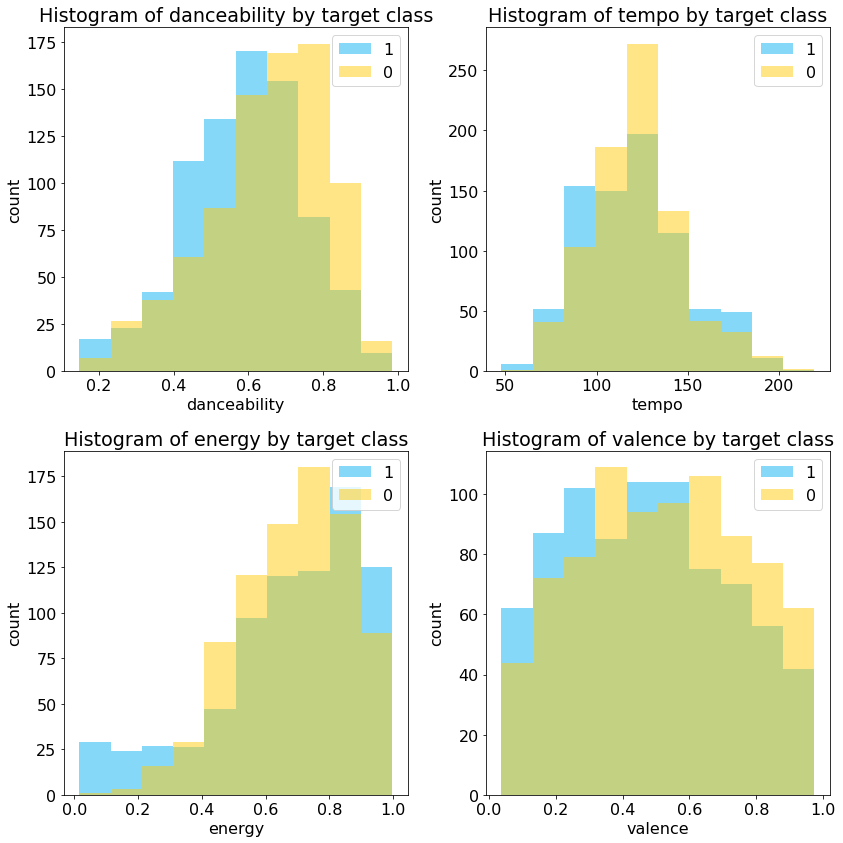

In [32]:
pos = df_train.query("target == 1")
neg = df_train.query("target == 0")
labels = ['0', '1']
colors = [(1, 0.8, 0.05, 0.5), (0.05, 0.7, 0.95, 0.5)]
fig, ((p1, p2), (p3, p4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plots = [p1, p2, p3, p4]
features = ['danceability', 'tempo', 'energy', 'valence'] 

for i in range(4):
    plot = plots[i]
    feature = features[i]
    plot.hist([pos[feature], neg[feature]], histtype='stepfilled', color=colors, label=labels)
    plot.set_title(f'Histogram of {feature} by target class')
    plot.set_xlabel(feature)
    plot.set_ylabel('count')
    plot.legend()

fig.tight_layout()


<img src='loudness.png' width="400">

(You don't have to match all the details exactly, such as colour, but your histograms should look something like this, with a reasonable number of bins to see the shape of the distribution.) As shown above, there are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram above shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of your loop, which draws the figure and resets the canvas for your next plot.

Here is some code that separates out the dataset into positive and negative examples, to help you get started:

In [33]:
negative_examples = df_train.query("target == 0")
positive_examples = df_train.query("target == 1")

#### 1(e)
rubric={points:4}

Let's say you had to make a decision stump (decision tree with depth 1), _by hand_, to predict the target class. Just from looking at the plots above, describe a reasonable split (feature name and threshold) and what class you would predict in the two cases. For example, in the loudness histogram provided earlier on, it seems that very large values of loudness are generally disliked (more blue on the right side of the histogram), so you might answer something like this: "A reasonable split would be to predict 0 if loudness > -5 (and predict 1 otherwise)."

A reasonable split would be to predict 0 if dancability > 0.7 (and predict 1 otherwise)

#### 1(f)
rubric={points:2}

Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class?



Yes it does mean the feautre is not useful for predicitng the target class. If the histograms of that feature are identical it means the that at every value the feature has equal probability of making the target 1 or 0. 

#### 1(g) 
rubric={points:2}

Note that the dataset includes two free text features labeled `song_title` and `artist`:

In [34]:
df_train[["song_title", "artist"]].head()

,song_title,artist
260,WTF (Where They From) [feat. Pharrell Williams],Missy Elliott
1286,"10,000 Reasons (Bless the Lord) [Radio Version]",Matt Redman
1344,American Dream,Chelsea Grin
1197,Feel This Moment,Pitbull
119,Trap Queen,Fetty Wap


- Do you think these features could be useful in predicting whether the user liked the song or not? 
- Would there be any difficulty in using them in your model?   

I do believe that the `artist` feature could be useful in predicitng whether the user liked a song or not, as many users have favorite `artist`s. it would be difficult to include them in the model because the values are discrete, and there would be lots of them.

The `song_title` feature on the otherhand is unlikely to be useful in predicitng whether the user liked a song or not, unless the user has a preference for songs on certain subjects or with similar `song_title`s. In this case it would still be difficult to include them in the model as to realize any value from the feature we would likely need to perform some natural language processing on the `song_title`s. 

## Exercise 2: Using sklearn to build a decision tree classifier

#### 2(a) 
rubric={points:2}

- Create `X_train` and `y_train` and `X_test` and `y_test` from `df_train` and `df_test` above. Skip the `song_title` and `artist` features for now. 
- Fit a `DecisionTreeClassifier` on the train set.

In [35]:
X_train = df_train.drop(columns=["target", "song_title", "artist"])
X_test = df_test.drop(columns=["target", "song_title", "artist"])

y_train = df_train["target"]
y_test = df_test["target"]

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

#### 2(b)
rubric={points:2}

Use the `predict` method to predict the class of the first example in your `X_train`. Is the prediction correct? That is, does it match with the corresponding class in `y_train`?  

> Hint: you can grab the first example with `X_train.iloc[[0]]`.

In [36]:
pred = model.predict(X_train.iloc[[0]])
print(pred, y_train.iloc[0])

[1] 1


Yes it does match with the corresponding class in `y_train` 

#### 2(c) 
rubric={points:2}

Use the `cross_val_score` function on your training set to compute the 10-fold cross-validation accuracy of your tree. 

In [46]:
cv_scores = cross_val_score(model, X_train, y_train, cv=10)
cv_scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### 2(d)
rubric={points:2}

The above is useful, but we would like to see the training accuracy as well. 

- Compute the 10-fold cross-validation again but this time using the `cross_validate` function with `return_train_score=True`. 
- Print out both the cross-validation score and the training score.
- Is your cross-validation score exactly the same as what you got in the previous part? Very briefly discuss.

In [47]:
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002993,0.000876,1.0,1.0
1,0.002620,0.000847,1.0,1.0
2,0.002667,0.001416,1.0,1.0
3,0.002887,0.000879,1.0,1.0
4,0.003006,0.001100,1.0,1.0
5,0.002914,0.000936,1.0,1.0
6,0.002508,0.000843,1.0,1.0
7,0.002777,0.000988,1.0,1.0
8,0.002847,0.001179,1.0,1.0
9,0.002755,0.000856,1.0,1.0


They are exactly the same. This is because `cross_validate` is just a more powerful version of `cross_val_score` that lets sus see training scores as well as test scores.

#### 2(e)
rubric={points:1}

Do you see a significant difference between the training score and the cross-validation score? Briefly discuss.

No there is no difference between the training score and cross-validation score. 


#### 2(f)
rubric={points:1}

Inspect the 10 sub-scores from the 10 folds of cross-validation. How does this inform the trustworthiness of your cross validation score?

## Exercise 3: Hyperparameters 
rubric={points:10}

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

- Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with different values of `max_depth` (at least 10 different values in the range 1 to 25).
- For each `max_depth`, get both the train accuracy and the cross-validation accuracy.
- Make a plot with `max_depth` on the *x*-axis and the train and cross-validation scores on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. Include a legend to specify which is which.
- Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy. From these results, what depth would you pick as the optimal depth? 
- Do you think that the depth you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 2") if you do so.

## Exercise 4: Test set
rubric={points:4}

Remember the test set you created way back at the beginning of this assignment? Let's use it now to see if our cross-validation score from the previous exercise is trustworthy. 

- Select your favorite `max_depth` from the previous part.
- Train a decision tree classifier using that `max_depth` on the _entire training set_.
- Compute and display the test score. 
- How does it compare to the cross-validation score from the previous exercise? Briefly discuss. 

## Exercise 5: Conceptual questions
rubric={points:3}

Consider the dataset below, which has $6$ examples and $2$ features:

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}-1\\-1\\+1\\+1\\+1\\+1\end{bmatrix}.$$

1. Say we fit a decision stump (depth 1 decision tree) and the first split is on the first feature (left column) being less than 5.5. What would we predict in the "true" and "false" cases here?
2. What training accuracy would the above stump get on this data set?
3. Can we obtain 100% accuracy with a single decision stump in this particular example?

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 